In [1]:
# importing necessary packages
from torch import flatten
from torch.optim import Adam
from torch import nn
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader,TensorDataset,Dataset
from torch.utils.data import random_split
from PIL import Image
from torch.nn.utils.rnn import pad_sequence  # pad batch
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import spacy  # for tokenizer
import time
import os
import re
import time

!python -m spacy download en_core_web_sm
torch.cuda.empty_cache()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.5 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible

In [2]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

  Preparing metadata (setup.py) ... - done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=ffd8c49305deea12c9e1cfb835882ab12416a6de5915fc1bde1cadba49abe93c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 11% |  2% |


In [3]:
# configuring path
data_path = '../input/stanford-image-paragraph-captioning-dataset/'
image_path = data_path + 'stanford_img/content/stanford_images/'
csv_file_path = data_path + 'stanford_df_rectified.csv'
output_path = '../working/'
model_path = output_path + 'model/'
!mkdir "$model_path"

**Data Cleaning**

In [4]:
abbreviations = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
     "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    "who'd": "who would",
    "who're": "who are",
    "'re": " are",
    "tryin'": "trying",
    "doesn'": "does not",
    'howdo': 'how do',
    'whatare': 'what are',
    'howcan': 'how can',
    'howmuch': 'how much',
    'howmany': 'how many',
    'whydo': 'why do',
    'doI': 'do I',
    'theBest': 'the best',
    'howdoes': 'how does',
}

In [5]:
def clean(df):
    col = "Paragraph"   # dataframe col name to clean   
    df = clean_lower(df,col)
    df = clean_math(df,col)
    df = clean_abbreviation(df, abbreviations,col)
    df = clean_space(df,col)
    df = clean_repeated_words(df,col)
    return df

def clean_lower(df,col):
    df[col] = df[col].apply(lambda x: x.lower())
    return df

def clean_lower(df,col):
    df[col] = df[col].apply(lambda x: x.lower())
    return df

def clean_abbreviation(df, abbreviations,col):
    compiled_abbreviation = re.compile('(%s)' % '|'.join(abbreviations.keys()))
    def replace(match):
        return abbreviations[match.group(0)]
    df[col] = df[col].apply(
        lambda x: _clean_abreviation(x, compiled_abbreviation, replace)
    )
    return df
    
def _clean_abreviation(x, compiled_re, replace):
    return compiled_re.sub(replace, x)

def clean_space(df,col):
    compiled_re = re.compile(r"\s+")
    df[col] = df[col].apply(lambda x: _clean_space(x, compiled_re))
    return df
def _clean_space(x, compiled_re):
    return compiled_re.sub(" ", x)

def clean_repeated_words(df,col):
    df[col] = df[col].apply(lambda x: re.sub(r'\b(\w+\s*)\1{1,}', '\\1', x))
    return df

def clean_math(df,col):
    math_puncts = 'θπα÷⁴≠β²¾∫≥⇒¬∠＝∑Φ√½¼'
    math_puncts_long = [r'\\frac', r'\[math\]', r'\[/math\]', r'\\lim']
    compiled_math = re.compile('(%s)' % '|'.join(math_puncts))
    compiled_math_long = re.compile('(%s)' % '|'.join(math_puncts_long))
    df[col] = df[col].apply(lambda x: _clean_math(x, compiled_math_long))
    df[col] = df[col].apply(lambda x: _clean_math(x, compiled_math))
    return df

def _clean_math(x, compiled_re):
    return compiled_re.sub(' <math> ', x)


In [6]:
# putting images inside train and test folder
df = pd.read_csv(csv_file_path)
df = clean(df)

**Data Analysis**

In [7]:
# added new column about caption length and word count in the caption 
df['Paragraph_Len'] = df['Paragraph'].astype(str).map(len)
df['Word_count'] = df['Paragraph'].apply(lambda x: len(str(x).split()))

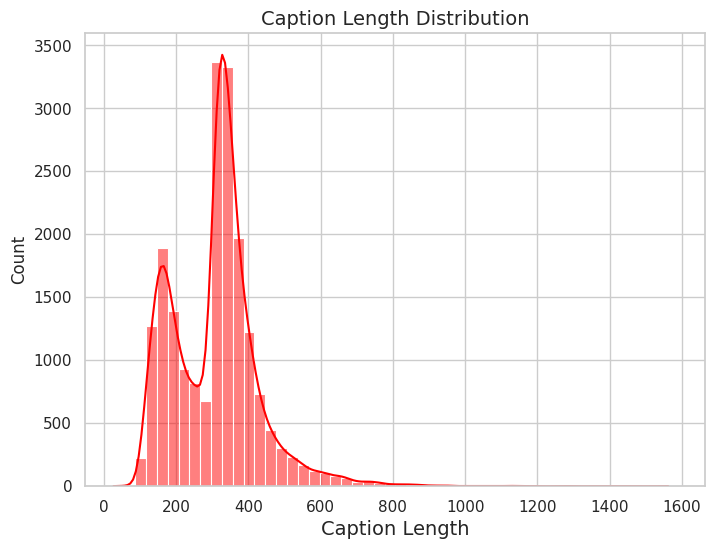

In [8]:
plt.figure(figsize=(8,6),dpi=100)
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.histplot(data=df, x="Paragraph_Len",binwidth=30,color='red',kde=True)
plt.title('Caption Length Distribution', fontsize=14)
plt.xlabel('Caption Length', fontsize=14)
file_path = model_path
plt.savefig(file_path + 'Lenght_dist.png',bbox_inches = 'tight') 
plt.show()
plt.close()

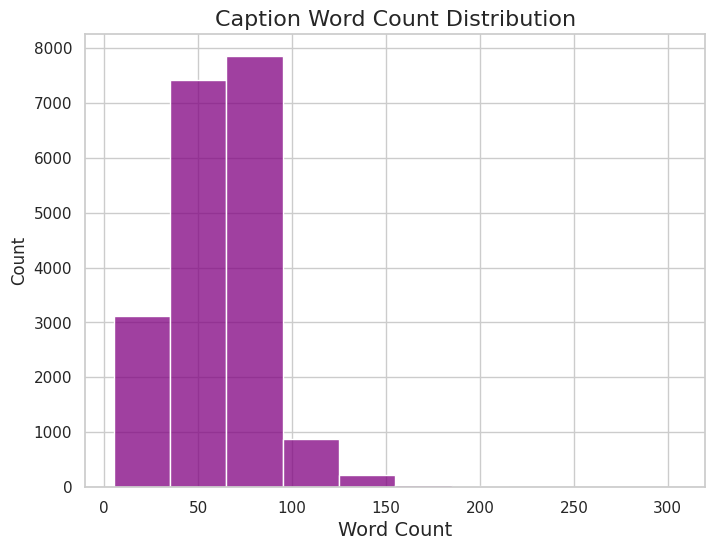

In [9]:
plt.figure(figsize=(8,6),dpi=100)
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.histplot(data=df, x="Word_count",binwidth=30,color='purple')
plt.title('Caption Word Count Distribution', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.savefig(model_path + 'Word_count.png',bbox_inches = 'tight') 
plt.show()
plt.close()

**Train-Test Split**

In [10]:
# data separation
df_train = df [(df['test'] == False)]
df_test = df [(df['test'] == True)]
df_train, df_val = train_test_split(df_train,test_size=0.33,random_state=0)

In [11]:
# saving the file
df_train.to_csv(output_path + 'stanford_df_train_rectified.csv', sep='\t',index=False)
df_test.to_csv(output_path + 'stanford_df_test_rectified.csv', sep='\t',index=False)
df_val.to_csv(output_path + 'stanford_df_val_rectified.csv', sep='\t',index=False)

**Data Analysis**

------------------Training Data Info -----------------------
-----------------Dataframe Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11436 entries, 0 to 11435
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_name     11436 non-null  int64 
 1   Paragraph      11436 non-null  object
 2   train          11436 non-null  bool  
 3   test           11436 non-null  bool  
 4   url            11436 non-null  object
 5   val            11436 non-null  bool  
 6   Paragraph_Len  11436 non-null  int64 
 7   Word_count     11436 non-null  int64 
dtypes: bool(3), int64(3), object(2)
memory usage: 480.3+ KB
None
--------------Column Null Values Count--------------------
Image_name       0
Paragraph        0
train            0
test             0
url              0
val              0
Paragraph_Len    0
Word_count       0
dtype: int64
----------Checking for Duplicate Values----------------
Image

Text(0, 0.5, 'No. Of Images')

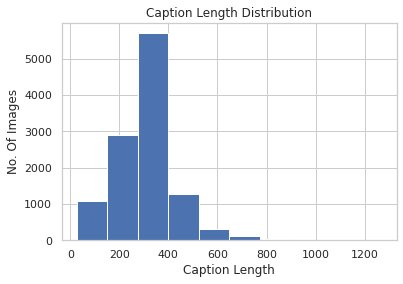

In [12]:
#Data Checking

df_train = pd.read_csv(output_path + 'stanford_df_train_rectified.csv',sep='\t')

print('------------------Training Data Info -----------------------')

print('-----------------Dataframe Info------------------')
print(f'{df_train.info()}')
#1.Checking Null Values in whole file
print('--------------Column Null Values Count--------------------')
print(df_train.isna().sum())
#2.Checking For Duplicated Values
print("----------Checking for Duplicate Values----------------")
print(f'Image Name contain duplicate values -- {df_train.duplicated(subset=["Image_name"]).any()}')
print(f'Paragraph contain duplicate values -- {df_train.duplicated(subset=["Paragraph"]).any()}')
print('----Removing Duplicate Entries------')
print(f'Dataframe shape --- {df_train.shape}')
if df_train.duplicated(subset=["Image_name"]).any():
    df_train.drop_duplicates(subset=['Image_name'], inplace=True)
if df_train.duplicated(subset=["Paragraph"]).any():
    df_train.drop_duplicates(subset=['Paragraph'], inplace=True)
print(f'Dataframe Shape after removal -- {df_train.shape}')
print(f"Max Caption Length -- {df_train['Paragraph_Len'].max()}")
# Resetting Index
df_train.reset_index(drop=True,inplace=True)
print('-------------------------------------------------------------------------')
# Caption Length Distribution
df_train.Paragraph_Len.hist();
plt.title("Caption Length Distribution")
plt.xlabel("Caption Length")
plt.ylabel("No. Of Images")

------------------Validation Data Info -----------------------
-----------------Dataframe Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5633 entries, 0 to 5632
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_name     5633 non-null   int64 
 1   Paragraph      5633 non-null   object
 2   train          5633 non-null   bool  
 3   test           5633 non-null   bool  
 4   url            5633 non-null   object
 5   val            5633 non-null   bool  
 6   Paragraph_Len  5633 non-null   int64 
 7   Word_count     5633 non-null   int64 
dtypes: bool(3), int64(3), object(2)
memory usage: 236.7+ KB
None
--------------Column Null Values Count--------------------
Image_name       0
Paragraph        0
train            0
test             0
url              0
val              0
Paragraph_Len    0
Word_count       0
dtype: int64
----------Checking for Duplicate Values----------------
Image

Text(0, 0.5, 'No. Of Images')

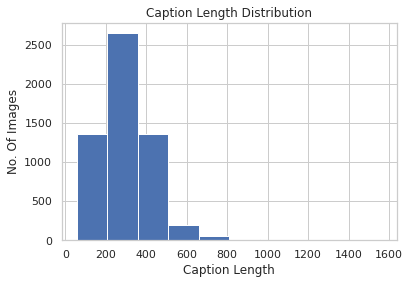

In [13]:
#Data Checking

df_val = pd.read_csv(output_path + 'stanford_df_val_rectified.csv',sep='\t')

print('------------------Validation Data Info -----------------------')

print('-----------------Dataframe Info------------------')
print(f'{df_val.info()}')
#1.Checking Null Values in whole file
print('--------------Column Null Values Count--------------------')
print(df_val.isna().sum())
#2.Checking For Duplicated Values
print("----------Checking for Duplicate Values----------------")
print(f'Image Name contain duplicate values -- {df_val.duplicated(subset=["Image_name"]).any()}')
print(f'Paragraph contain duplicate values -- {df_val.duplicated(subset=["Paragraph"]).any()}')
print('----Removing Duplicate Entries------')
print(f'Dataframe shape --- {df_val.shape}')
if df_val.duplicated(subset=["Image_name"]).any():
    df_val.drop_duplicates(subset=['Image_name'], inplace=True)
if df_val.duplicated(subset=["Paragraph"]).any():
    df_val.drop_duplicates(subset=['Paragraph'], inplace=True)
print(f'Dataframe Shape after removal -- {df_val.shape}')
print(f"Max Caption Length -- {df_val['Paragraph_Len'].max()}")
# Resetting Index
df_val.reset_index(drop=True,inplace=True)
print('-------------------------------------------------------------------------')
# Caption Length Distribution
df_val.Paragraph_Len.hist();
plt.title("Caption Length Distribution")
plt.xlabel("Caption Length")
plt.ylabel("No. Of Images")

In [14]:
#Data Checking

df_test = pd.read_csv(output_path + 'stanford_df_test_rectified.csv',sep='\t')

print('------------------Test Data Info -----------------------')

print('-----------------Dataframe Info------------------')
print(f'{df_test.info()}')
#1.Checking Null Values in whole file
print('--------------Column Null Values Count--------------------')
print(df_test.isna().sum())
#2.Checking For Duplicated Values
print("----------Checking for Duplicate Values----------------")
print(f'Image Name contain duplicate values -- {df_test.duplicated(subset=["Image_name"]).any()}')
print(f'Paragraph contain duplicate values -- {df_test.duplicated(subset=["Paragraph"]).any()}')
print('----Removing Duplicate Entries------')
print(f'Dataframe shape --- {df_test.shape}')
if df_test.duplicated(subset=["Image_name"]).any():
    df_test.drop_duplicates(subset=['Image_name'], inplace=True)
if df_test.duplicated(subset=["Paragraph"]).any():
    df_test.drop_duplicates(subset=['Paragraph'], inplace=True)
print(f'Dataframe Shape after removal -- {df_test.shape}')
print(f"Max Caption Length -- {df_test['Paragraph_Len'].max()}")
# Resetting Index
df_test.reset_index(drop=True,inplace=True)

------------------Test Data Info -----------------------
-----------------Dataframe Info------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_name     2492 non-null   int64 
 1   Paragraph      2492 non-null   object
 2   train          2492 non-null   bool  
 3   test           2492 non-null   bool  
 4   url            2492 non-null   object
 5   val            2492 non-null   bool  
 6   Paragraph_Len  2492 non-null   int64 
 7   Word_count     2492 non-null   int64 
dtypes: bool(3), int64(3), object(2)
memory usage: 104.8+ KB
None
--------------Column Null Values Count--------------------
Image_name       0
Paragraph        0
train            0
test             0
url              0
val              0
Paragraph_Len    0
Word_count       0
dtype: int64
----------Checking for Duplicate Values----------------
Image Name 

**Utility Function**

In [15]:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(filename, model, optimizer):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    
    print(f'Model {filename} trained for {epoch} Epoch.')
    for parameter in model.parameters():
        parameter.requires_grad = False

    return model
   

**Data Loading**

In [16]:
# define training hyperparameters
INIT_LR = 3e-4
BATCH_SIZE = 64
EPOCHS = 60
EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1


# set the device we will be using to train the model
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

In [17]:
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class ImageCaptionDataset(Dataset):
    """Image Captioning Dataset"""

    def __init__(self,img_dir,df,transform,freq_threshold=5):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

         # Get img, caption columns
        self.imgs = self.df['Image_name']
        self.captions = self.df["Paragraph"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def custom_pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f).convert("RGB")
            img.load()
            return img

    def __getitem__(self,idx):
        image_path = os.path.join(self.img_dir,str(self.imgs[idx]) + '.jpg')
        image = self.custom_pil_loader(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        caption = self.captions[idx]
        # converting caption to numberical form
        # every word of caption will represent index in vocabulary
        # SOS - starting of sentence EOS - end of sentence
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(image_dir,df,transform,batch_size=BATCH_SIZE,num_workers=2,shuffle=True):
    dataset = ImageCaptionDataset(image_dir,df,transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    loader = DataLoader(dataset=dataset,batch_size=batch_size,num_workers=num_workers,shuffle=shuffle,pin_memory=True,collate_fn=MyCollate(pad_idx=pad_idx))
    return loader, dataset


In [18]:
# load the image captioning dataset
print("[INFO] loading the image captioning train,test and val dataset...")
# transform = transforms.Compose([
#             transforms.Resize((356, 356)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#        ])

transform = transforms.Compose([ 
    transforms.Resize(356),                       
    transforms.RandomCrop(324,324),                      
    transforms.RandomHorizontalFlip(p=0.5),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])
print("[INFO] generating the train,validation and test data loaders ...")

# initialize the train, validation data loaders
train_data_loader,train_dataset = get_loader(image_dir = image_path,df = df_train,transform=transform,shuffle=True)
val_data_loader,val_dataset = get_loader(image_dir = image_path,df = df_val,transform=transform,shuffle=True)
test_data_loader,test_dataset = get_loader(image_dir = image_path,df = df_test,transform=transform,shuffle=True)

# calculate steps per epoch for training and validation set
train_steps = len(train_dataset) // BATCH_SIZE
val_steps = len(val_dataset) // BATCH_SIZE

print(f'Training Steps Per Epoch -- {train_steps}')
print(f'Validation Steps Per Epoch -- {val_steps}')

# Preview the length dictionary.
print(f'Dictionary Size -- {len(train_dataset.vocab)}')

[INFO] loading the image captioning train,test and val dataset...
[INFO] generating the train,validation and test data loaders ...
Training Steps Per Epoch -- 178
Validation Steps Per Epoch -- 88
Dictionary Size -- 3618


**CNN Model**

In [19]:
class DenseNetCNN(nn.Module):
    def __init__(self, embed_size,dropout):

        super(DenseNetCNN, self).__init__()
        # get the pretrained densenet model
        self.densenet = models.densenet121(pretrained=True)
       
        self.embed = nn.Linear(self.densenet.classifier.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.densenet.classifier = self.embed
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)

        

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, images):
        
        # get the embeddings from the densenet
        features = self.densenet(images)
        for param in self.densenet.parameters():
            param.requires_grad_(False)
#         print(features.size())   
#         features = self.relu(features)
#         features = features.view(features.size(0), -1)
#         print(features.size()) 
        # pass through the fully connected
#         features = features.view(features.size(0), -1)
        embeddings = self.dropout(self.relu(features))
#         embeddings = self.dropout(self.prelu(densenet_outputs))
        return embeddings

In [20]:
class Resnet50CNN(nn.Module):
    def __init__(self, embed_size,dropout):
        super(Resnet50CNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch= nn.BatchNorm1d(embed_size,momentum = 0.01)
        self.embed.weight.data.normal_(0., 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch(self.embed(features))
        return features

In [21]:
class InceptionCNN(nn.Module):
    def __init__(self,embed_size,dropout,train_CNN=False):
        super(InceptionCNN,self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True,aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features,embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,images):
        features = self.inception(images)

        for name,param in self.inception.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_CNN
        return self.dropout(self.relu(features))

**RNN Model**

In [22]:
class LSTMRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers):
        super(LSTMRNN,self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers)
        self.linear = nn.Linear(hidden_size,vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,features,captions):
        embeddings = self.dropout(self.embed(captions))
        features = features.unsqueeze(0)
        embeddings = torch.cat((features,embeddings),dim=0)
        hiddens,_ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

CNN->RNN Model

In [23]:
class CNNToRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,encoderCNN,decoderRNN,num_layers=1,dropout=0.5):
        super(CNNToRNN,self).__init__()
        self.encoderCNN = encoderCNN(embed_size,dropout)
        self.decoderRNN = decoderRNN(embed_size,hidden_size,vocab_size,num_layers)

    def forward(self,images,captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features,captions)
        return outputs

    def caption_image(self,image,vocabulary,max_length):
        result_caption = []
        
        with torch.no_grad():
            x = model.encoderCNN(image.to(device)).unsqueeze(0)
            states = None
          
            for _ in range(max_length):
                hiddens,states = self.decoderRNN.lstm(x,states)
                outputs = self.decoderRNN.linear(hiddens)
                outputs = outputs.squeeze(1)
                # predict the most likely next word, max_indice shape : (1)
                _, max_indice = torch.max(outputs, dim=1) 
                predicted_word = max_indice.cpu().numpy()[0].item()
                result_caption.append(predicted_word) # storing the word predicted
                ## Prepare to embed the last predicted word to be the new input of the lstm
                x = self.decoderRNN.embed(max_indice).unsqueeze(0)
          
                if vocabulary.itos[predicted_word] == "<EOS>" or max_indice == 2:
                    # We predicted the <end> word, so there is no further prediction to do
                    break
        
        
        return " ".join([vocabulary.itos[idx] for idx in  result_caption])

**Model Training**

In [24]:
def train(model,opt,lossFn,filename):
    # initialize a dictionary to store training history
    H = {
       "train_loss": [],
        "val_loss": [],
         "val_acc": []
       }
    # measure how long training is going to take
    print("[INFO] training the network...")
    start_time = time.time()
    step = 0
    
    # loop over our epochs
    for e in range(0, EPOCHS):
        # set the model in training mode
        model.train()
        # initialize the total training and validation loss
        total_train_loss = 0
        total_val_loss = 0
        
        # Save the model checkpoints
        if save_model:
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer' : opt.state_dict(),
                 'epoch': e,
            }
    
            save_checkpoint(checkpoint,filename)
    
        for idx,(imgs, captions) in enumerate(train_data_loader):
            
            # send the input to the device
            (imgs, captions) = (imgs.to(device), captions.to(device))

            # captions[:-1] -> Discard the <end> word to avoid predicting when <end> is the input of the RNN 

            # perform a forward pass and calculate the training loss
            outputs = model(imgs,captions[:-1] )
            # Calculate the batch loss
            loss = lossFn( outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        
            # zero out the gradients, perform the backpropagation step,
            # and update the weights
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far and
            # calculate the number of correct predictions
            total_train_loss += loss
            step += 1

            if idx % BATCH_SIZE == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(e, EPOCHS, idx, train_steps, loss.item(), np.exp(loss.item()))) 
                end_time = time.time()
                print("[INFO] time elapsed so far to train the model: {:.2f}s".format(end_time - start_time))

        
        print('[INFO] validation started for Epoch [{}/{}]'.format(e, EPOCHS))
        with torch.no_grad():
          # set the model in evaluation mode
          model.eval()
          # loop over the validation set
          for idx,(imgs, captions) in enumerate(val_data_loader):
            # send the input to the device
            (imgs, captions) = (imgs.to(device), captions.to(device))
            # perform a forward pass and calculate the training loss
            outputs = model(imgs,captions[:-1])
        
            # Calculate the batch loss
            loss = lossFn( outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            total_val_loss += loss
      
        end_time = time.time()
        print("[INFO] validation completed for Epoch [{}/{}] and time elapsed so far {:.2f}s".format(e, EPOCHS,end_time - start_time))
        # calculate the average training and validation loss
        avg_train_loss = total_train_loss / train_steps
        avg_val_loss = total_val_loss / val_steps

        # update our training history
        H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
        H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
        print("Train loss: {:.6f}".format(avg_train_loss))
        print("Val loss: {:.6f}\n".format(avg_val_loss))

    # finish measuring how long training took
    end_time = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))
    return H


**Model Prediction**

In [25]:
# function to get predction from test dataset
from torchtext.data.metrics import bleu_score
def get_prediction(model,num_image_show = 2):
    count = 0
    max_count = num_image_show
    for row in df_test.itertuples():
        raw_image_path = image_path + str(row.Image_name) + '.jpg'
        raw_image = Image.open(raw_image_path).convert("RGB")
        caption = row.Paragraph
        plt.figure()   # create a new figure
        plt.imshow(raw_image)
        plt.title('Image')
        plt.show()
        print('\n --------Ground Truth-------------- \n')
        print(caption)
        prediction = _get_prediction(model,raw_image)
        prediction = post_processing(prediction)
        prediction_word_list = prediction.split(' ')
        print('\n -------Predicted----------- \n')
        print(prediction)
        plt.close()    # close the figure to show the next one.
        count += 1
        time.sleep(2)
        if count >= max_count:
              break

def get_bleu_score(model):
    candidate_corpus = []
    reference_corpus = []
    for row in df_test.itertuples():
        raw_image_path = image_path + str(row.Image_name) + '.jpg'
        raw_image = Image.open(raw_image_path).convert("RGB")
        caption = row.Paragraph
        candidate_corpus.append(caption.split(' '))
        prediction = _get_prediction(model,raw_image)
        prediction = post_processing(prediction)
        prediction_word_list = prediction.split(' ')
        reference_corpus.append(prediction_word_list)
    print(f'BLEU Score --- {bleu_score(candidate_corpus, reference_corpus,max_n=3)}')


def _get_prediction(model,image):
    transform = transforms.Compose(
            [
                transforms.Resize((299, 299)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
    image = transform(image).unsqueeze(0)
    sentence = model.caption_image(image,vocabulary=train_dataset.vocab,max_length = df_test['Paragraph_Len'].max())
    return sentence

def post_processing(sentence):
    # removing extra space
    compiled_re = re.compile(r"\s+")
    sentence = compiled_re.sub(" ", sentence)
    # removing repeated words
    sentence = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', sentence)
    return sentence

def project_test_image_prediction(model):
    image_name = ['test_1','test_2','test_3']
    image_path = '../input/images/'
    for img_name in image_name:
        raw_image_path = image_path + img_name + '.jpeg'
        raw_image = Image.open(raw_image_path).convert("RGB")
        plt.figure()   # create a new figure
        plt.imshow(raw_image)
        plt.title('Image')
        plt.show()
        prediction = _get_prediction(model,raw_image)
        prediction = post_processing(prediction)
        prediction_word_list = prediction.split(' ')
        print('\n -------Predicted----------- \n')
        print(prediction)
        plt.close()    # close the figure to show the next one.
        time.sleep(2)
    

RESNET50-LSTM

In [26]:
# initialize the Encoder/Decoder model
print("[INFO] initializing the Encoder/Decoder model...")
VOCAB_SIZE=len(train_dataset.vocab)
model = CNNToRNN(embed_size = EMBED_SIZE,hidden_size = HIDDEN_SIZE,vocab_size=VOCAB_SIZE,
                 num_layers = NUM_LAYERS,encoderCNN=Resnet50CNN,decoderRNN=LSTMRNN).to(device)
# initialize our optimizer and loss function
lossFn = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
opt = Adam(model.parameters(), lr=INIT_LR)

[INFO] initializing the Encoder/Decoder model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
# model training
# filename = model_path + 'resnet_50_lstm_epoch_25_batch_64_checkpoint.pth.tar'
filename = model_path + 'resnet_50_lstm_epoch_50_batch_32_checkpoint.pth.tar'

model_performance = train(model,opt,lossFn,filename)

[INFO] training the network...
=> Saving checkpoint
Epoch [0/60], Step [0/178], Loss: 8.2013, Perplexity: 3645.5324
[INFO] time elapsed so far to train the model: 9.29s
Epoch [0/60], Step [64/178], Loss: 5.2623, Perplexity: 192.9230
[INFO] time elapsed so far to train the model: 61.91s
Epoch [0/60], Step [128/178], Loss: 4.6974, Perplexity: 109.6635
[INFO] time elapsed so far to train the model: 116.96s
[INFO] validation started for Epoch [0/60]
[INFO] validation completed for Epoch [0/60] and time elapsed so far 233.71s
[INFO] EPOCH: 1/60
Train loss: 5.522230
Val loss: 5.533437

=> Saving checkpoint
Epoch [1/60], Step [0/178], Loss: 4.4874, Perplexity: 88.8902
[INFO] time elapsed so far to train the model: 235.89s
Epoch [1/60], Step [64/178], Loss: 4.3238, Perplexity: 75.4729
[INFO] time elapsed so far to train the model: 283.98s
Epoch [1/60], Step [128/178], Loss: 4.3258, Perplexity: 75.6254
[INFO] time elapsed so far to train the model: 331.16s
[INFO] validation started for Epoch [1

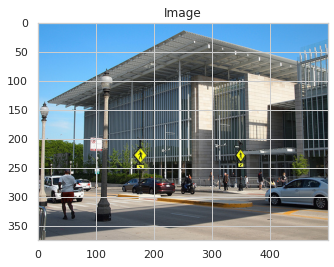


 --------Ground Truth-------------- 

a large building with bars on the windows in front of it. there is people walking in front of the building. there is a street in front of the building with many cars on it. 

 -------Predicted----------- 

<SOS> a large white and blue bus is parked on the street . there is a large white building behind the bus . there is a large building behind the bus . <EOS>


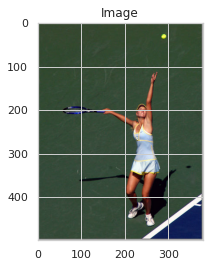


 --------Ground Truth-------------- 

a woman in a blue tennis outfit stands on a green tennis court. she is swinging a blue tennis racket. there is a green tennis ball above her head. 

 -------Predicted----------- 

<SOS> a man is standing on a tennis court . he is wearing a white shirt and black shorts . he is holding a tennis racket in his hands . the man is wearing a white shirt and black shorts . the man is wearing a white shirt and black shorts . the man is holding a tennis racket in his hands . the man is wearing a white shirt and black shorts . the man is wearing a white shirt and black shorts . the man is wearing a white shirt and black shorts . the man is holding a tennis racket in his hand . the court is green and white . <EOS>


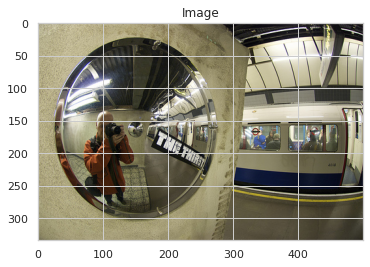


 --------Ground Truth-------------- 

the man is taking a photo in the round mirror. he is bald. he is wearing an orange jacket. his camera is black. there is a train in the mirror too. 

 -------Predicted----------- 

<SOS> a large white airplane is parked on the runway . there is a large white airplane in the front of the plane . there is a large white airplane in the sky . <EOS>


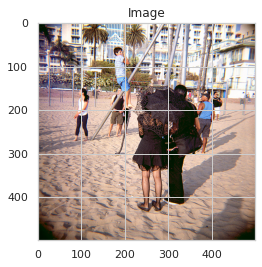


 --------Ground Truth-------------- 

people are on a play ground standing in the sand. a boy in a blue shirt and blue pants are climbing the pole. the woman in brown is holding a brown umbrella. there are people shadows on the ground.

 -------Predicted----------- 

<SOS> a man is standing on a grassy field . he is wearing a black and white uniform . he is holding a black and white frisbee in his hand . he is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black helmet . the man is wearing a black helmet and a black 

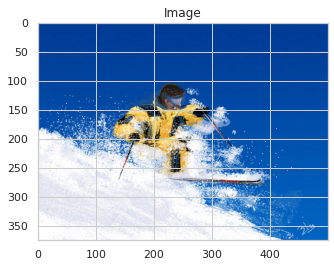


 --------Ground Truth-------------- 

a person is skiing through the snow. there is loose snow all around them from him jumping. the person is wearing a yellow snow suit. the person is holding two ski poles in their hands. 

 -------Predicted----------- 

<SOS> a man is surfing on a wave . the man is wearing a blue shirt and blue shorts . the man is wearing a black wet suit . the man is wearing a black wet suit . the man is holding a surfboard . the man is wearing a black wet suit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wetsuit . the man is wearing a black wet

In [28]:
# predicting output
get_prediction(model,5)

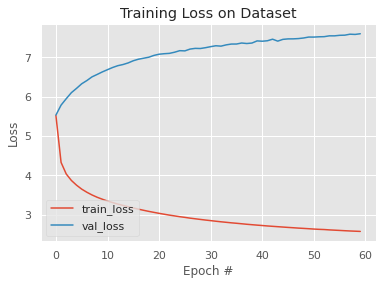

In [29]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(model_performance["train_loss"], label="train_loss")
plt.plot(model_performance["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(output_path + 'resnet_loss.png',bbox_inches = 'tight') 

**InceptionCNN-LSTM**

In [30]:
# initialize the Encoder/Decoder model
print("[INFO] initializing the Encoder/Decoder model...")
VOCAB_SIZE=len(train_dataset.vocab)
model = CNNToRNN(embed_size = EMBED_SIZE,hidden_size = HIDDEN_SIZE,vocab_size=VOCAB_SIZE,
                 num_layers = NUM_LAYERS,encoderCNN=InceptionCNN,decoderRNN=LSTMRNN).to(device)
# initialize our optimizer and loss function
lossFn = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
opt = Adam(model.parameters(), lr=INIT_LR)

[INFO] initializing the Encoder/Decoder model...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [31]:
# model training
filename = model_path + 'inception_lstm_epoch_100_batch_64_checkpoint.pth.tar'
model_performance = train(model,opt,lossFn,filename)

[INFO] training the network...
=> Saving checkpoint
Epoch [0/60], Step [0/178], Loss: 8.2091, Perplexity: 3674.2193
[INFO] time elapsed so far to train the model: 5.66s
Epoch [0/60], Step [64/178], Loss: 5.0238, Perplexity: 151.9814
[INFO] time elapsed so far to train the model: 49.65s
Epoch [0/60], Step [128/178], Loss: 4.6771, Perplexity: 107.4582
[INFO] time elapsed so far to train the model: 95.60s
[INFO] validation started for Epoch [0/60]
[INFO] validation completed for Epoch [0/60] and time elapsed so far 193.14s
[INFO] EPOCH: 1/60
Train loss: 5.450061
Val loss: 5.500469

=> Saving checkpoint
Epoch [1/60], Step [0/178], Loss: 4.4016, Perplexity: 81.5850
[INFO] time elapsed so far to train the model: 195.27s
Epoch [1/60], Step [64/178], Loss: 4.3549, Perplexity: 77.8626
[INFO] time elapsed so far to train the model: 241.50s
Epoch [1/60], Step [128/178], Loss: 4.1317, Perplexity: 62.2837
[INFO] time elapsed so far to train the model: 288.75s
[INFO] validation started for Epoch [1/

In [32]:
# model evaluation
filename = '../input/inception-pre-trained-model/inception_lstm_epoch_100_batch_64_100_checkpoint.pth.tar'
model = load_checkpoint(filename, model, opt)
model.eval()

=> Loading checkpoint
Model ../input/inception-pre-trained-model/inception_lstm_epoch_100_batch_64_100_checkpoint.pth.tar trained for 99 Epoch.


CNNToRNN(
  (encoderCNN): InceptionCNN(
    (inception): Inception3(
      (Conv2d_1a_3x3): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2a_3x3): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (Conv2d_2b_3x3): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv2d_3b_1x1): BasicConv2d(
        (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine

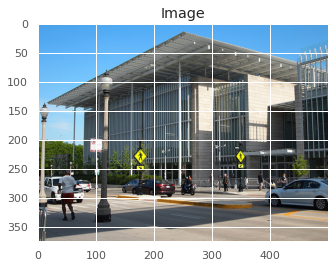


 --------Ground Truth-------------- 

a large building with bars on the windows in front of it. there is people walking in front of the building. there is a street in front of the building with many cars on it. 

 -------Predicted----------- 

<SOS> a large white building is sitting on a street . there is a white building behind the building . there is a white building behind the building . <EOS>


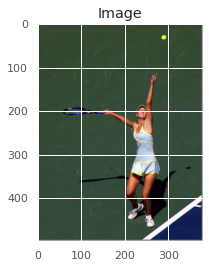


 --------Ground Truth-------------- 

a woman in a blue tennis outfit stands on a green tennis court. she is swinging a blue tennis racket. there is a green tennis ball above her head. 

 -------Predicted----------- 

<SOS> a man is standing on a tennis court . he is wearing a white shirt and blue shorts . he is holding a tennis racket in his hand . the court is green and green . the court is green and green . the court is green and green . <EOS>


In [33]:
# predicting output
get_prediction(model,2)

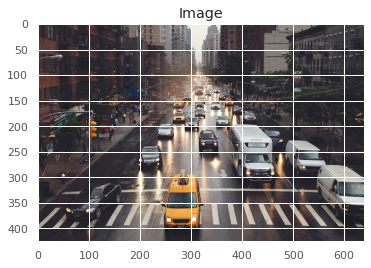


 -------Predicted----------- 

<SOS> a large white building is sitting on a street . there is a white building behind the bus . there is a white building behind the bus . there is a white building behind the bus . <EOS>


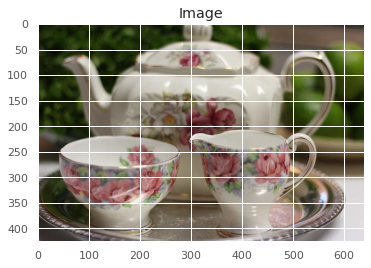


 -------Predicted----------- 

<SOS> a white plate with a white plate on top of it . there is a white plate on top of the table . there is a white plate on top of the table . there is a white plate on top of the table . <EOS>


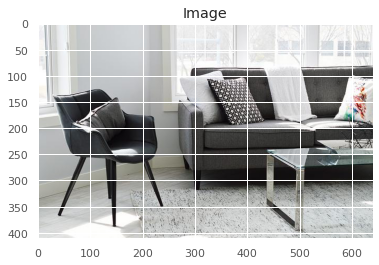


 -------Predicted----------- 

<SOS> a white couch is sitting on a bed . there is a white couch in front of the couch . there is a white chair in front of the couch . there is a white chair in front of the couch . there is a white chair in front of the couch . <EOS>


In [34]:
# Test Images for Live Project Viva
project_test_image_prediction(model)

**DenseNetCNN-LSTM**

In [35]:
# initialize the Encoder/Decoder model
print("[INFO] initializing the Encoder/Decoder model...")
VOCAB_SIZE=len(train_dataset.vocab)
model = CNNToRNN(embed_size = EMBED_SIZE,hidden_size = HIDDEN_SIZE,vocab_size=VOCAB_SIZE,
                 num_layers = 1,encoderCNN=DenseNetCNN,decoderRNN=LSTMRNN).to(device)
# initialize our optimizer and loss function
lossFn = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])
opt = Adam(model.parameters(),lr=INIT_LR)

[INFO] initializing the Encoder/Decoder model...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [36]:
filename = model_path + 'densenet_lstm_epoch_60_batch_64_checkpoint.pth.tar'

model_performance = train(model,opt,lossFn,filename)

[INFO] training the network...
=> Saving checkpoint


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 15.90 GiB total capacity; 14.45 GiB already allocated; 29.75 MiB free; 14.49 GiB reserved in total by PyTorch)

In [ ]:
# predicting output
get_prediction(model,50)